# RL w/ Verifiable Rewards Experiments  

running locally so bear with me; sticking to smol models and toy-ish tasks to start with

#### imports

In [1]:
import os, re, random, math, json
import torch
from dataclasses import dataclass
from collections import deque
from typing import List, Tuple
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from tqdm.auto import tqdm

from typing import List, Dict, Tuple
from datasets import Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig
from trl import GRPOConfig, GRPOTrainer
from peft import LoraConfig
from transformers import TrainerCallback
import time

### measure baseline accuracy (no RL)  

In [ ]:


MODEL_ID = os.environ.get("MODEL_ID", "Qwen/Qwen3-0.6B")  # swap to ...-Instruct if you have it
DEVICE = "cuda"
DTYPE = torch.float32
LOAD_IN_4BIT = True  # flip to False if bitsandbytes is problematic under WSL2
N_EVAL = 100  # TODO: increase later

# Keep outputs short and verifiable. No chain-of-thought; just the number.
SYSTEM_PROMPT = (
    "You are a calculator. Solve the user's math problem and reply with an integer. "
    "ASCII characters only, no markdown. "
    "Your final answer should be on a new line at the end of your response. "
)

def build_messages(problem: str):
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": problem},
    ]

# Extract the last integer-like token (handles negatives)
NUM_RE = re.compile(r"[-+]?\d+")

def parse_answer(text: str) -> int | None:
    matches = NUM_RE.findall(text.strip())
    if not matches:
        return None
    return int(matches[-1])

def gen_synthetic_math(n: int = 500, seed: int = 0) -> List[Tuple[str, int]]:
    rng = random.Random(seed)
    items = []
    for _ in range(n):
        a = rng.randint(-99999, 99999)
        b = rng.randint(-99999, 99999)
        op = rng.choice(["+", "-", "*"])
        if op == "+":
            ans = a + b
            prob = f"{a} + {b} = ?"
        elif op == "-":
            ans = a - b
            prob = f"{a} - {b} = ?"
        elif op == "*":
            # keep magnitudes modest to avoid huge products
            a2 = rng.randint(-50, 50)
            b2 = rng.randint(-50, 50)
            ans = a2 * b2
            prob = f"{a2} * {b2} = ?"
        else:
            raise ValueError("Invalid mathematical operation.")
        items.append((prob, int(ans)))
    return items

# Harder task generators (to lower baseline accuracy)
def _sample_int(rng: random.Random, low: int, high: int) -> int:
    x = rng.randint(low, high)
    if x == 0:
        x = rng.choice([low, high, 1, -1])
    return x

def gen_ltr_arithmetic(n: int = 500, seed: int = 0, min_steps: int = 4, max_steps: int = 7, add_sub_range: int = 9999, mul_range: int = 50) -> List[Tuple[str, int]]:
    rng = random.Random(seed)
    ops = ['+','-','*']
    items: List[Tuple[str, int]] = []
    for _ in range(n):
        steps = rng.randint(min_steps, max_steps)
        ops_selected = [rng.choice(ops) for _ in range(steps)]
        nums = []
        for i in range(steps + 1):
            rng_mul = (i > 0 and ops_selected[i-1] == '*')
            nums.append(_sample_int(rng, -mul_range, mul_range) if rng_mul else _sample_int(rng, -add_sub_range, add_sub_range))
        tokens = []
        for i in range(steps):
            tokens.append(str(nums[i]))
            tokens.append(ops_selected[i])
        tokens.append(str(nums[-1]))
        expr = ' '.join(tokens)
        res = nums[0]
        for i, op in enumerate(ops_selected):
            b = nums[i+1]
            if op == '+': res = res + b
            elif op == '-': res = res - b
            elif op == '*': res = res * b
        prompt = (
            f'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n'
            f'{expr}\n'
            f'What is the result?'
        )
        items.append((prompt, int(res)))
    return items

def gen_word_multi_step(n: int = 500, seed: int = 0, min_ops: int = 3, max_ops: int = 5, value_range: int = 9999, mul_range: int = 50) -> List[Tuple[str, int]]:
    rng = random.Random(seed)
    items: List[Tuple[str, int]] = []
    verbs = {'+':'add','-':'subtract','*':'multiply by'}
    for _ in range(n):
        k = rng.randint(min_ops, max_ops)
        ops = [rng.choice(list(verbs.keys())) for _ in range(k)]
        start = _sample_int(rng, -value_range, value_range)
        vals = []
        for op in ops:
            vals.append(_sample_int(rng, -mul_range, mul_range) if op=='*' else _sample_int(rng, -value_range, value_range))
        res = start
        parts = [f'Start with {start}.']
        for op, v in zip(ops, vals):
            if op=='+': res = res + v; parts.append(f'Then add {v}.')
            elif op=='-': res = res - v; parts.append(f'Then subtract {v}.')
            elif op=='*': res = res * v; parts.append(f'Then multiply by {v}.')
        parts.append('What is the result?')
        prompt = ' '.join(parts)
        items.append((prompt, int(res)))
    return items

def measure_baseline_accuracy():
    kwargs = dict(
        dtype=DTYPE,
        device_map="auto",
        trust_remote_code=True,
    )
    if LOAD_IN_4BIT:
        kwargs.update(dict(quantization_config=BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float32)))
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, **kwargs)
    tok = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id
    # Align model/generation config with tokenizer to avoid warnings
    model.config.pad_token_id = tok.pad_token_id
    model.config.eos_token_id = tok.eos_token_id
    model.config.bos_token_id = getattr(tok, 'bos_token_id', None)
    if hasattr(model, 'generation_config'):
        model.generation_config.pad_token_id = tok.pad_token_id
        model.generation_config.eos_token_id = tok.eos_token_id
        model.generation_config.bos_token_id = getattr(tok, 'bos_token_id', None)
    # Ensure dtype alignment of embeddings + head and retie (eval baseline)
    try:
        base = model
        # (eval baseline) optional dtype diagnostics
        base = model
        emb_in = base.get_input_embeddings()
        emb_out = base.get_output_embeddings() or getattr(base, 'lm_head', None)
        try:
            print('in_emb:', emb_in.weight.dtype if emb_in is not None else None, 'out_emb:', emb_out.weight.dtype if emb_out is not None else None)
        except Exception:
            pass
    except Exception:
        pass

    torch.backends.cuda.matmul.allow_tf32 = True
    model.eval()

    # data = gen_synthetic_math(n=N_EVAL, seed=123)
    data = gen_word_multi_step(n=N_EVAL, seed=123)
    correct = 0
    samples = []

    for i, (problem, ans) in tqdm(enumerate(data)):
        messages = build_messages(problem)
        text = tok.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True, enable_thinking=False
        )
        inputs = tok(text, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model.generate(
                **inputs,
                max_new_tokens=999,
                do_sample=False,
                temperature=0.0,
                eos_token_id=tok.eos_token_id,
                pad_token_id=tok.pad_token_id,
            )
        gen = tok.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
        pred = parse_answer(gen)
        is_ok = (pred == ans)
        correct += int(is_ok)

        if i < 10:  # keep a few examples
            samples.append({"problem": problem, "gold": ans, "raw": gen.strip(), "pred": pred, "ok": bool(is_ok)})

    acc = correct / len(data)
    print(json.dumps({"model": MODEL_ID, "n": len(data), "accuracy": acc, "samples": samples}, indent=2))



In [18]:
measure_baseline_accuracy()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


0it [00:00, ?it/s]

{
  "model": "Qwen/Qwen3-0.6B",
  "n": 100,
  "accuracy": 0.83,
  "samples": [
    {
      "problem": "-86273 + -29830 = ?",
      "gold": -116103,
      "raw": "-86273 + -29830 = -86273 - 29830 = -116103.",
      "pred": -116103,
      "ok": true
    },
    {
      "problem": "6756 + -30124 = ?",
      "gold": -23368,
      "raw": "6756 + (-30124) = 6756 - 30124 = -23368.",
      "pred": -23368,
      "ok": true
    },
    {
      "problem": "21 * -8 = ?",
      "gold": -168,
      "raw": "21 * -8 = -168.",
      "pred": -168,
      "ok": true
    },
    {
      "problem": "-10661 + -86394 = ?",
      "gold": -97055,
      "raw": "-10661 + -86394 = -97055",
      "pred": -97055,
      "ok": true
    },
    {
      "problem": "-8 * 39 = ?",
      "gold": -312,
      "raw": "-8 * 39 = -312",
      "pred": -312,
      "ok": true
    },
    {
      "problem": "-35731 + -57066 = ?",
      "gold": -92797,
      "raw": "-35731 + -57066 = -35731 - 57066 = -92797.",
      "pred": -92797,
     

### RL w/ Verifiable Rewards (GRPO)  

In [ ]:
# train GRPO


# ----- Config / Knobs -----
MODEL_ID = os.environ.get("MODEL_ID", "Qwen/Qwen3-0.6B")  # base (non-instruct) + strict system prompt
DTYPE = torch.bfloat16                       # non-quantized bf16 for training
LOAD_IN_4BIT = False                         # keep off for training; eval can use 4-bit
SEED = 42

# Run profile: quick sanity vs full
QUICK_RUN = True
TRAIN_SAMPLES_QUICK, EVAL_SAMPLES_QUICK = 1024, 32
TRAIN_SAMPLES_FULL,  EVAL_SAMPLES_FULL  = 4000, 200
MAX_STEPS_QUICK,     MAX_STEPS_FULL     = 400,  3000

# Token lengths
MAX_PROMPT_TOK = 128
MAX_COMPLETION_TOK = 64                    # math answers are short; saves compute

# GRPO sampling
NUM_GENERATIONS = 8                        # group size G in GRPO; 8 typical; generation batch sz must be divisible by this
PER_DEVICE_TRAIN_BATCH = 8                # ensure divisible by NUM_GENERATIONS globally
GRAD_ACCUM_STEPS = 1

# Task hardness knobs
TASK_MODE = 'simple'        # 'simple' | 'ltr' | 'word'
LTR_MIN_STEPS, LTR_MAX_STEPS = 4, 7
WORD_MIN_OPS,  WORD_MAX_OPS  = 3, 5
VAL_RANGE, MUL_RANGE = 9999, 50

# Optim / schedule
LEARNING_RATE = 2e-5  # faster
LR_SCHEDULER = 'cosine'
WARMUP_RATIO = 0.1

# Logging / eval / saving
LOGGING_STEPS = 2
EVAL_STEPS = 50
SAVE_STEPS = 200
SAVE_TOTAL_LIMIT = 2
RUN_NAME = 'grpo-math-quick' if QUICK_RUN else 'grpo-math-full'
OUTPUT_DIR = f'qwen3-06b-{RUN_NAME}'

# ----- Prompt rendering with chat template -----
REWARD_BUFFER: deque[float] = deque(maxlen=2048)
REWARD_EMA: float | None = None
REWARD_ALPHA: float = 0.9
def _pairs_to_rows(pairs: List[Tuple[str, int]]) -> List[Dict[str, int]]:
    return [{"problem": p, "gold": int(g)} for p, g in pairs]

def render_prompts(rows: List[Dict[str, int]]) -> Dataset:
    tok = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id
    tok.padding_side = "left"

    def _render(row):
        problem = row.get("problem", row.get("0"))
        gold = row.get("gold", row.get("1"))
        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": problem},
        ]
        # Render to a single prompt string that already includes the assistant tag.
        prompt = tok.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True, enable_thinking=False
        )
        return {"prompt": prompt, "gold": gold}

    ds = Dataset.from_list(rows)
    return ds.map(_render, remove_columns=list(ds.column_names))

# Verifiable reward: use same logic as checking base SFT'ed model
def reward_correct_integer(completions: List[str], gold: List[int], **kwargs) -> List[float]:
    rewards = []
    for out, gt in zip(completions, gold):
        pred = parse_answer(out)
        rewards.append(1.0 if pred == gt else 0.0)
    # Update running reward stats for logging
    try:
        REWARD_BUFFER.extend(rewards)
        mean_r = (sum(rewards) / len(rewards)) if rewards else 0.0
        global REWARD_EMA
        REWARD_EMA = mean_r if REWARD_EMA is None else (REWARD_ALPHA * REWARD_EMA + (1 - REWARD_ALPHA) * mean_r)
    except Exception:
        pass
    return rewards

def train_grpo_integer_math(quick_run: bool | None = None):
    random.seed(SEED)
    if quick_run is None:
        quick_run = QUICK_RUN
    n_train = TRAIN_SAMPLES_QUICK if quick_run else TRAIN_SAMPLES_FULL
    n_eval  = EVAL_SAMPLES_QUICK  if quick_run else EVAL_SAMPLES_FULL
    max_steps = MAX_STEPS_QUICK  if quick_run else MAX_STEPS_FULL

    if TASK_MODE == 'simple':
        train_pairs = gen_synthetic_math(n=n_train, seed=SEED)
        eval_pairs  = gen_synthetic_math(n=n_eval,  seed=SEED + 1)
    elif TASK_MODE == 'ltr':
        train_pairs = gen_ltr_arithmetic(n=n_train, seed=SEED, min_steps=LTR_MIN_STEPS, max_steps=LTR_MAX_STEPS, add_sub_range=VAL_RANGE, mul_range=MUL_RANGE)
        eval_pairs  = gen_ltr_arithmetic(n=n_eval,  seed=SEED + 1, min_steps=LTR_MIN_STEPS, max_steps=LTR_MAX_STEPS, add_sub_range=VAL_RANGE, mul_range=MUL_RANGE)
    elif TASK_MODE == 'word':
        train_pairs = gen_word_multi_step(n=n_train, seed=SEED, min_ops=WORD_MIN_OPS, max_ops=WORD_MAX_OPS, value_range=VAL_RANGE, mul_range=MUL_RANGE)
        eval_pairs  = gen_word_multi_step(n=n_eval,  seed=SEED + 1, min_ops=WORD_MIN_OPS, max_ops=WORD_MAX_OPS, value_range=VAL_RANGE, mul_range=MUL_RANGE)
    else:
        raise ValueError(f'Unknown TASK_MODE={TASK_MODE}')
    train_rows = _pairs_to_rows(train_pairs)
    eval_rows  = _pairs_to_rows(eval_pairs)
    train_ds = render_prompts(train_rows)
    eval_ds  = render_prompts(eval_rows)

    # ---- Helpers & Monitoring ----
    def _bytes_to_gib(x: int) -> float:
        return x / (1024 ** 3)

    def _gpu_mem_stats(dev: int = 0) -> dict:
        if torch.cuda.is_available():
            free_b, total_b = torch.cuda.mem_get_info(dev)
            alloc_b = torch.cuda.memory_allocated(dev)
            reserv_b = torch.cuda.memory_reserved(dev)
            return {
                'free_gib': _bytes_to_gib(free_b),
                'total_gib': _bytes_to_gib(total_b),
                'used_gib': _bytes_to_gib(total_b - free_b),
                'alloc_gib': _bytes_to_gib(alloc_b),
                'reserved_gib': _bytes_to_gib(reserv_b),
            }
        return {'free_gib': 0.0, 'total_gib': 0.0, 'used_gib': 0.0, 'alloc_gib': 0.0, 'reserved_gib': 0.0}

    class MemoryMonitorCallback(TrainerCallback):
        def __init__(self, device: int = 0, alpha: float = 0.3):
            self.device = device
            self.alpha = alpha
            self._last_t = None
            self._last_step = 0
            self._ema_step_t = None
            self.csv_path = None
        def on_train_begin(self, args, state, control, **kwargs):
            self._last_t = time.time()
            ms = _gpu_mem_stats(self.device)
            self.csv_path = f"{args.output_dir}/mem_log.csv"
            try:
                with open(self.csv_path, 'w') as f:
                    f.write('time,step,used_gib,alloc_gib,reserved_gib,usage_pct,ema_step_s,approx_tok_s,approx_seq_s\n')
            except Exception:
                self.csv_path = None
            if state.is_world_process_zero:
                print(f"[mem] start used={ms['used_gib']:.2f}GiB free={ms['free_gib']:.2f}GiB total={ms['total_gib']:.2f}GiB reserved={ms['reserved_gib']:.2f}GiB")
        def on_log(self, args, state, control, **kwargs):
            now = time.time()
            step_delta = state.global_step - self._last_step if self._last_step is not None else 0
            dt = now - self._last_t if self._last_t is not None else 0.0
            step_t = (dt / step_delta) if step_delta else None
            if step_t is not None:
                self._ema_step_t = step_t if self._ema_step_t is None else (self.alpha * step_t + (1 - self.alpha) * self._ema_step_t)
            ms = _gpu_mem_stats(self.device)
            logs = kwargs.get('logs', {})
            if state.is_world_process_zero:
                usage = (ms['used_gib'] / ms['total_gib'] * 100.0) if ms['total_gib'] else 0.0
                global_batch = args.per_device_train_batch_size * args.world_size
                toks_per_step_est = global_batch * (args.num_generations or 1) * (args.max_completion_length or 1)
                tok_s = (toks_per_step_est / self._ema_step_t) if (self._ema_step_t and toks_per_step_est) else None
                seq_s = (global_batch * (args.num_generations or 1) / self._ema_step_t) if self._ema_step_t else None
                eta_s = ((args.max_steps - state.global_step) * self._ema_step_t) if (self._ema_step_t and args.max_steps) else None
                eta_str = (f"ETA~{int(eta_s // 60)}m{int(eta_s % 60)}s" if eta_s else "ETA~na")
                # Reward stats (from global buffer updated in reward function)
                try:
                    rb_len = len(REWARD_BUFFER)
                    reward_rate = (sum(REWARD_BUFFER) / rb_len) if rb_len else 0.0
                    reward_ema  = REWARD_EMA if REWARD_EMA is not None else reward_rate
                except Exception:
                    reward_rate, reward_ema = 0.0, 0.0
                logs.update({
                    'gpu_used_gib': ms['used_gib'],
                    'gpu_alloc_gib': ms['alloc_gib'],
                    'gpu_reserved_gib': ms['reserved_gib'],
                    'gpu_usage_pct': usage,
                    'ema_step_s': self._ema_step_t or 0.0,
                    'approx_tok_s': tok_s or 0.0,
                    'approx_seq_s': seq_s or 0.0,
                    'train_reward_rate': reward_rate,
                    'train_reward_ema': reward_ema,
                })
                print(f"[mem][step {state.global_step}] used={ms['used_gib']:.2f}GiB ({usage:.0f}%) alloc={ms['alloc_gib']:.2f}GiB resv={ms['reserved_gib']:.2f}GiB step_t={(self._ema_step_t or 0):.2f}s tok/s~{(tok_s or 0):.0f} seq/s~{(seq_s or 0):.1f} reward~{reward_rate:.3f} ema~{reward_ema:.3f} {eta_str}")
                if self.csv_path:
                    try:
                        with open(self.csv_path, 'a') as f:
                            f.write(f"{int(now)},{state.global_step},{ms['used_gib']:.4f},{ms['alloc_gib']:.4f},{ms['reserved_gib']:.4f},{usage:.2f},{(self._ema_step_t or 0):.4f},{(tok_s or 0):.2f},{(seq_s or 0):.2f}\n")
                    except Exception:
                        pass
            self._last_t, self._last_step = now, state.global_step
        def on_evaluate(self, args, state, control, **kwargs):
            ms = _gpu_mem_stats(self.device)
            if state.is_world_process_zero:
                print(f"[mem][eval ] used={ms['used_gib']:.2f}GiB free={ms['free_gib']:.2f}GiB reserved={ms['reserved_gib']:.2f}GiB")
        def on_save(self, args, state, control, **kwargs):
            ms = _gpu_mem_stats(self.device)
            if state.is_world_process_zero:
                print(f"[mem][save ] used={ms['used_gib']:.2f}GiB free={ms['free_gib']:.2f}GiB reserved={ms['reserved_gib']:.2f}GiB")

    class QuickEvalCallback(TrainerCallback):
        def __init__(self, tok, eval_pairs, n_quick: int = 16, device: str = 'cuda', max_new_tokens: int = MAX_COMPLETION_TOK):
            self.tok = tok
            self.eval_pairs = eval_pairs[:n_quick] if eval_pairs else []
            self.device = device
            self.max_new_tokens = max_new_tokens
            self._trainer = None
            self.prompts = []
            for p, _g in self.eval_pairs:
                messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": p}]
                self.prompts.append(self.tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False))
        def set_trainer(self, trainer):
            self._trainer = trainer
        def on_evaluate(self, args, state, control, **kwargs):
            if not (state.is_world_process_zero and self._trainer and self.prompts):
                return
            model = self._trainer.model
            tok = self.tok
            n = len(self.prompts)
            correct = 0
            for i in range(n):
                text = self.prompts[i]
                inputs = tok(text, return_tensors='pt').to(args.device if hasattr(args, 'device') else self.device)
                with torch.no_grad():
                    out = model.generate(**inputs, max_new_tokens=self.max_new_tokens, do_sample=False, temperature=0.0, eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id)
                gen = tok.decode(out[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                pred = parse_answer(gen)
                gold = self.eval_pairs[i][1]
                correct += int(pred == gold)
            acc = correct / max(1, n)
            print(f"[qe][step {state.global_step}] acc_quick={acc*100:.1f}% on {n}")

    # LoRA for small, fast updates (QLoRA if LOAD_IN_4BIT=True)
    lora = LoraConfig(
        r=16, lora_alpha=32, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM",
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]
    )

    # GRPO configuration (grouped sampling, KL via DAPO loss)
    # Enable fast matmul on Ampere+
    torch.backends.cuda.matmul.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass

    args = GRPOConfig(
        output_dir=OUTPUT_DIR,
        seed=SEED,
        tf32=True,
        bf16=(DTYPE == torch.bfloat16),
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS,
        learning_rate=LEARNING_RATE,
        lr_scheduler_type=LR_SCHEDULER,
        warmup_ratio=WARMUP_RATIO,
        logging_strategy='steps',
        logging_first_step=True,
        logging_steps=LOGGING_STEPS,
        save_strategy='steps',
        save_steps=SAVE_STEPS,
        save_total_limit=SAVE_TOTAL_LIMIT,
        eval_strategy='steps',
        eval_steps=EVAL_STEPS,
        max_steps=max_steps,
        run_name=RUN_NAME,
        report_to='none',
        max_prompt_length=MAX_PROMPT_TOK,
        max_completion_length=MAX_COMPLETION_TOK,
        # steps_per_generation=None,
        num_generations=NUM_GENERATIONS,    # group size G; used for group-relative baseline
        temperature=1.0,                    # allow exploration
        top_p=0.9,
        # GRPO-specific knobs:
        beta=0.05,                          # KL strength
        epsilon=0.2,                        # clipping (GRPO’s PPO-style clip)
        scale_rewards="group",              # subtract group mean (relative baseline)
        loss_type="dapo",                   # TRL default; KL in loss
        # Optional speed/memory extras:
        # use_liger_loss=True,              # enable if you pip-install TRL[liger] from source
        # use_vllm=True,                    # if you want an external vLLM server for gen
        # vllm_mode="colocate",
        # Model init (QLoRA):
        model_init_kwargs=dict(
            dtype=DTYPE,
            trust_remote_code=True,
            device_map="auto",
            **({
                "quantization_config": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float32)
            } if LOAD_IN_4BIT else {})
        ),
    )
    args.generation_batch_size = None

    tok = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id
    tok.padding_side = "left"

    mem_cb = MemoryMonitorCallback()
    qe_cb  = QuickEvalCallback(tok, eval_rows, n_quick=16, device=DEVICE, max_new_tokens=MAX_COMPLETION_TOK)
    trainer = GRPOTrainer(
        model=MODEL_ID,
        reward_funcs=reward_correct_integer,     # custom verifiable reward
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        processing_class=tok,                    # tokenizer for policy/ref processing
        peft_config=lora,
        callbacks=[mem_cb, qe_cb]
    )
    qe_cb.set_trainer(trainer)
    # Align model/generation config with tokenizer to avoid warnings
    model = trainer.model
    model.config.pad_token_id = tok.pad_token_id
    model.config.eos_token_id = tok.eos_token_id
    model.config.bos_token_id = getattr(tok, 'bos_token_id', None)
    if hasattr(model, 'generation_config'):
        model.generation_config.pad_token_id = tok.pad_token_id
        model.generation_config.eos_token_id = tok.eos_token_id
        model.generation_config.bos_token_id = getattr(tok, 'bos_token_id', None)
    # After TRL constructs the trainer (and internally re-created args),
    # restore a concrete generation_batch_size if it is None so downstream
    # dataloaders and samplers can derive batch/replication correctly.
    if trainer.args.generation_batch_size is None:
        trainer.args.generation_batch_size = (
            trainer.args.per_device_train_batch_size * trainer.args.world_size * trainer.args.steps_per_generation
        )

    trainer.train()
    trainer.save_model()  # PEFT adapter if LoRA; full if no PEFT
    try:
        trainer.save_state()  # ensure trainer_state.json exists for diagnostics
    except Exception:
        pass



In [4]:
train_grpo_integer_math()

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

[mem] start used=3.26GiB free=28.58GiB total=31.84GiB reserved=1.44GiB


`generation_config` default values have been modified to match model-specific defaults: {'temperature': 0.6}. If this is not desired, please set these values explicitly.
/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.000100,0.001277
100,0.000300,-0.000247
150,-0.014900,-0.001997
200,0.000100,0.003750


[mem][step 1] used=4.13GiB (13%) alloc=1.24GiB resv=2.29GiB step_t=6.62s tok/s~618 seq/s~9.7 ETA~21m57s
[mem][step 2] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=5.82s tok/s~703 seq/s~11.0 ETA~19m13s
[mem][step 4] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=5.44s tok/s~753 seq/s~11.8 ETA~17m46s
[mem][step 6] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=4.89s tok/s~837 seq/s~13.1 ETA~15m49s
[mem][step 8] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=4.55s tok/s~899 seq/s~14.1 ETA~14m34s
[mem][step 10] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=4.24s tok/s~967 seq/s~15.1 ETA~13m25s
[mem][step 12] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=4.07s tok/s~1006 seq/s~15.7 ETA~12m45s
[mem][step 14] used=4.14GiB (13%) alloc=1.24GiB resv=2.30GiB step_t=3.89s tok/s~1054 seq/s~16.5 ETA~12m2s
[mem][step 16] used=4.94GiB (15%) alloc=1.24GiB resv=3.10GiB step_t=4.20s tok/s~975 seq/s~15.2 ETA~12m52s
[mem][step 18] used=6.11GiB (19%) alloc=1.24GiB res

### train diagnostics + plotting

In [7]:
# Diagnostics & Plots
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def load_trainer_logs(output_dir: str) -> pd.DataFrame:
    p = Path(output_dir) / 'trainer_state.json'
    if not p.exists():
        raise FileNotFoundError(f'No trainer_state.json at {p}')
    with open(p) as f:
        st = json.load(f)
    df = pd.DataFrame(st.get('log_history', []))
    return df

def load_mem_log(output_dir: str) -> pd.DataFrame | None:
    p = Path(output_dir) / 'mem_log.csv'
    if not p.exists():
        return None
    df = pd.read_csv(p)
    return df

def plot_losses(df: pd.DataFrame):
    if df is None or df.empty:
        print('No trainer logs found.')
        return
    plt.figure(figsize=(8,4))
    if 'loss' in df:
        plt.plot(df.get('step', df.index), pd.to_numeric(df['loss'], errors='coerce'), label='train loss', alpha=0.7)
    if 'eval_loss' in df:
        plt.plot(df.get('step', df.index), pd.to_numeric(df['eval_loss'], errors='coerce'), label='eval loss', alpha=0.7)
    plt.xlabel('step'); plt.ylabel('loss'); plt.legend(); plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()

def plot_memory(dfm: pd.DataFrame | None):
    if dfm is None or dfm.empty:
        print('No mem_log.csv found.')
        return
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(dfm['step'], dfm['used_gib'], label='used GiB')
    ax[0].plot(dfm['step'], dfm['reserved_gib'], label='reserved GiB', alpha=0.6)
    ax[0].set_xlabel('step'); ax[0].set_ylabel('GiB'); ax[0].legend(); ax[0].grid(True, alpha=0.2)
    usage_col = 'gpu_usage_pct' if 'gpu_usage_pct' in dfm.columns else ('usage_pct' if 'usage_pct' in dfm.columns else None)
    if usage_col:
        ax[1].plot(dfm['step'], dfm[usage_col])
    else:
        # Fallback: approximate % from used/reserved if total unknown (skip if not present)
        try:
            approx = (pd.to_numeric(dfm['used_gib'], errors='coerce') / pd.to_numeric(dfm.get('total_gib', pd.NA), errors='coerce')) * 100.0
            if approx.notna().any():
                ax[1].plot(dfm['step'], approx)
        except Exception:
            pass
    ax[1].set_xlabel('step'); ax[1].set_ylabel('% used'); ax[1].grid(True, alpha=0.2)
    fig.tight_layout(); plt.show()
    if 'approx_tok_s' in dfm.columns:
        plt.figure(figsize=(8,3))
        plt.plot(dfm['step'], dfm['approx_tok_s'])
        plt.xlabel('step'); plt.ylabel('approx tok/s'); plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()

def summarize(df: pd.DataFrame, dfm: pd.DataFrame | None):
    out = {}
    if df is not None and not df.empty and 'loss' in df:
        out['final_train_loss'] = float(pd.to_numeric(df['loss'], errors='coerce').dropna().tail(1))
    if df is not None and not df.empty and 'eval_loss' in df:
        ev = pd.to_numeric(df['eval_loss'], errors='coerce').dropna()
        if len(ev):
            out['best_eval_loss'] = float(ev.min())
    if dfm is not None and len(dfm):
        out['peak_used_gib'] = float(dfm['used_gib'].max())
        if 'approx_tok_s' in dfm:
            vals = pd.to_numeric(dfm['approx_tok_s'], errors='coerce').replace({0: pd.NA}).dropna()
            out['mean_tok_s'] = float(vals.mean()) if len(vals) else 0.0
    print(out)




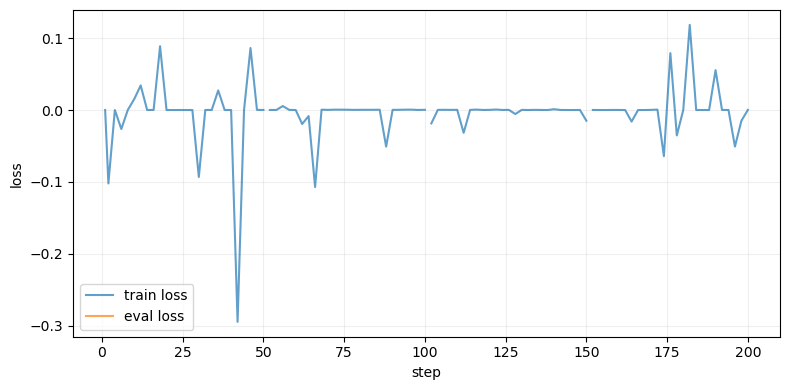

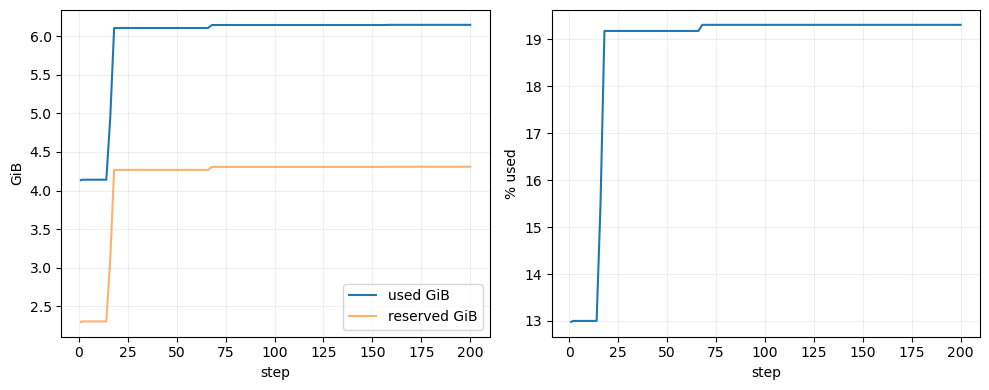

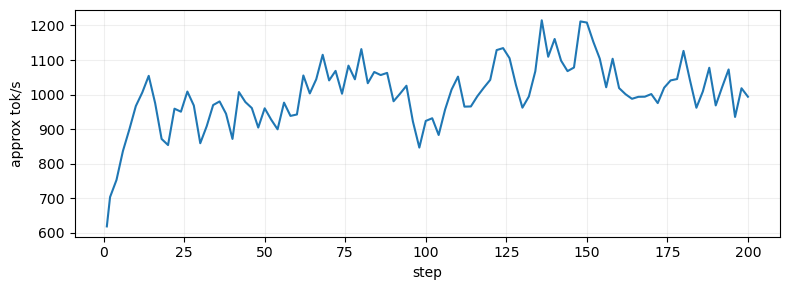

{'final_train_loss': 0.0001, 'best_eval_loss': -0.0019967935513705015, 'peak_used_gib': 6.15, 'mean_tok_s': 1001.1488679245283}


/tmp/ipykernel_668/376089731.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  out['final_train_loss'] = float(pd.to_numeric(df['loss'], errors='coerce').dropna().tail(1))


In [8]:
df = load_trainer_logs(OUTPUT_DIR)
dfm = load_mem_log(OUTPUT_DIR)

plot_losses(df)
plot_memory(dfm)
summarize(df, dfm)